In [ ]:
import matplotlib.pyplot as plt
import h5py
import numpy as np 
from ripser import Rips, ripser
from sklearn import preprocessing
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.stats import binned_statistic_2d, pearsonr
from scipy.sparse import coo_matrix
from scipy.linalg import eigh
from scipy.sparse.linalg import lsmr
from scipy import stats
from datetime import datetime 
import time
import functools
from scipy import signal
from scipy import optimize
import sys
import numba


C:\Users\erihe\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log


R_1_OF_day1


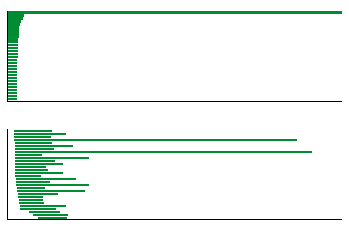

C:\Users\erihe\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log


R_2_OF_day1


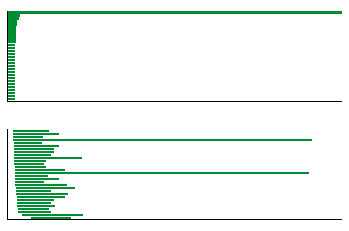

C:\Users\erihe\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log


R_3_OF_day1


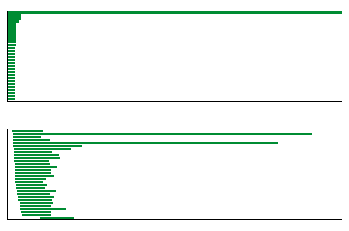

C:\Users\erihe\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log


R_1_WW_day1


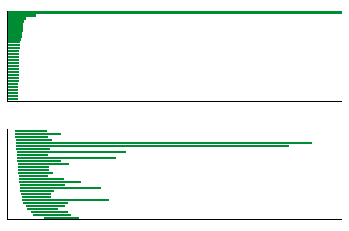

C:\Users\erihe\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log


R_2_WW_day1


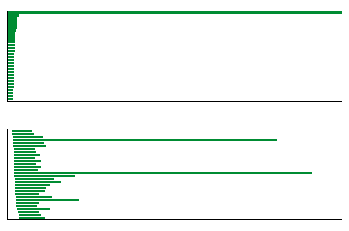

C:\Users\erihe\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log


R_3_WW_day1


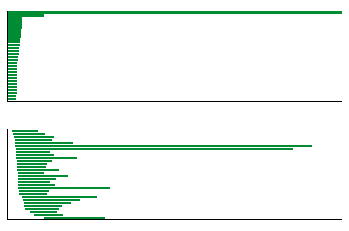

In [89]:
bRoll = False
dim = 6
ph_classes = [0,1] # Decode the ith most persistent cohomology class
num_circ = len(ph_classes)
dec_tresh = 0.99
metric = 'cosine'
maxdim = 1
coeff = 47
active_times = 15000
k = 1000
num_times = 5
n_points = 1200
nbs = 800
sigma = 1500

for rat_name, mod_name, sess_name, day_name in (('R', '1', 'OF', 'day1'),
                                                ('R', '2', 'OF', 'day1'),
                                                ('R', '3', 'OF', 'day1'),
                                                ('R', '1', 'WW', 'day1'),
                                                ('R', '2', 'WW', 'day1'),
                                                ('R', '3', 'WW', 'day1'),
#                                                ('R', '1', 'OF', 'day2'),
#                                                ('R', '2', 'OF', 'day2'),
#                                                ('R', '3', 'OF', 'day2'),
#                                                ('R', '1', 'REM', 'day2'),
#                                                ('R', '2', 'REM', 'day2'),
#                                                ('R', '3', 'REM', 'day2'),
#                                                ('R', '1', 'SWS', 'day2'),
#                                                ('R', '2', 'SWS', 'day2'),
#                                                ('R', '3', 'SWS', 'day2'),
#                                                ('Q', '1', 'OF', ''),
#                                                ('Q', '2', 'OF', ''),
#                                                ('Q', '1', 'WW', ''),
#                                                ('Q', '2', 'WW', ''),
#                                                ('Q', '1', 'REM', ''),
#                                                ('Q', '2', 'REM', ''),
#                                                ('Q', '1', 'SWS', ''),
#                                                ('Q', '2', 'SWS', ''),
#                                                ('S', '1', 'OF', ''),
#                                                ('S', '1', 'WW', ''),
#                                                ('S', '1', 'REM', ''),
#                                                ('S', '1', 'SWS', '')
                                                ):
    if sess_name in ('OF', 'WW'):
        sspikes,__,__,__,__ = get_spikes(rat_name, mod_name, day_name, sess_name, bType = 'pure',
                                         bSmooth = True, bSpeed = True)
    else:
        sspikes = get_spikes(rat_name, mod_name, day_name, sess_name, bType = 'pure', bSmooth = True, bSpeed = False)
        
    num_neurons = len(sspikes[0,:])

    if bRoll:
        np.random.seed(s)
        shift = np.zeros(num_neurons, dtype = int)
        for n in range(num_neurons):
            shifti = int(np.random.rand()*len(sspikes[:,0]))
            sspikes[:,n] = np.roll(sspikes[:,n].copy(), shifti)
            shift[n] = shifti
            
    times_cube = np.arange(0,len(sspikes[:,0]),num_times)
    movetimes = np.sort(np.argsort(np.sum(sspikes[times_cube,:],1))[-active_times:])
    movetimes = times_cube[movetimes]

    dim_red_spikes_move_scaled,__,__ = pca(preprocessing.scale(sspikes[movetimes,:]), dim = dim)
    indstemp,dd,fs  = sample_denoising(dim_red_spikes_move_scaled,  k, 
                                        n_points, 1, metric)
    dim_red_spikes_move_scaled = dim_red_spikes_move_scaled[indstemp,:]
    X = squareform(pdist(dim_red_spikes_move_scaled, metric))
    knn_indices = np.argsort(X)[:, :nbs]
    knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()
    sigmas, rhos = smooth_knn_dist(knn_dists, nbs, local_connectivity=0)
    rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
    result = coo_matrix((vals, (rows, cols)), shape=(X.shape[0], X.shape[0]))
    result.eliminate_zeros()
    transpose = result.transpose()
    prod_matrix = result.multiply(transpose)
    result = (result + transpose - prod_matrix)
    result.eliminate_zeros()
    d = result.toarray()
    d = -np.log(d)
    np.fill_diagonal(d,0)

    persistence = ripser(d, maxdim=maxdim, coeff=coeff, do_cocycles= True, distance_matrix = True)    
    plot_barcode(persistence['dgms'])    
    if len(day_name)>0:
        day_name = '_' + day_name
    print(rat_name + '_' + mod_name + '_' + sess_name + day_name )
    plt.show()
    
    np.savez_compressed('Toroidal_topology_grid_cell_data/Results/' + 
        rat_name + '_' + mod_name + '_' + sess_name + day_name  + '_persistence', 
        persistence = persistence, indstemp = indstemp,  movetimes = movetimes)
    day_name = day_name[1:]
    
    ############ Decode cocycles ################
    diagrams = persistence["dgms"] # the multiset describing the lives of the persistence classes
    cocycles = persistence["cocycles"][1] # the cocycle representatives for the 1-dim classes
    dists_land = persistence["dperm2all"] # the pairwise distance between the points 
    births1 = diagrams[1][:, 0] #the time of birth for the 1-dim classes
    deaths1 = diagrams[1][:, 1] #the time of death for the 1-dim classes
    deaths1[np.isinf(deaths1)] = 0
    lives1 = deaths1-births1 # the lifetime for the 1-dim classes
    iMax = np.argsort(lives1)
    coords1 = np.zeros((num_circ, len(indstemp)))
    threshold = births1[iMax[-2]] + (deaths1[iMax[-2]] - births1[iMax[-2]])*dec_tresh
    for c in ph_classes:
        cocycle = cocycles[iMax[-(c+1)]]
        coords1[c,:],inds = get_coords(cocycle, threshold, len(indstemp), dists_land, coeff)

    num_neurons = len(sspikes[0,:])
    centcosall = np.zeros((num_neurons, 2, n_points))
    centsinall = np.zeros((num_neurons, 2, n_points))
    dspk = preprocessing.scale(sspikes[movetimes[indstemp],:])

    for neurid in range(num_neurons):
        spktemp = dspk[:, neurid].copy()
        centcosall[neurid,:,:] = np.multiply(np.cos(coords1[:, :]*2*np.pi),spktemp)
        centsinall[neurid,:,:] = np.multiply(np.sin(coords1[:, :]*2*np.pi),spktemp)

    if sess_name in ('OF', 'WW'):
        sspikes,__,__,__,__ = get_spikes(rat_name, mod_name, day_name, sess_name, bType = 'pure',
                                         bSmooth = True, bSpeed = True, smoothing_width = sigma)
        spikes,__,__,__,__ = get_spikes(rat_name, mod_name, day_name, sess_name, bType = 'pure',
                                         bSmooth = False, bSpeed = True)
    else:
        sspikes = get_spikes(rat_name, mod_name, day_name, sess_name, bType = 'pure', bSmooth = True, bSpeed = False,
                             smoothing_width = sigma)
        spikes = get_spikes(rat_name, mod_name, day_name, sess_name, bType = 'pure', bSmooth = False, bSpeed = False)

    times = np.where(np.sum(spikes>0, 1)>=1)[0]
    dspk = preprocessing.scale(sspikes)
    sspikes = sspikes[times,:]
    dspk = dspk[times,:]

    a = np.zeros((len(sspikes[:,0]), 2, num_neurons))
    for n in range(num_neurons):
        a[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centcosall[n,:,:],1))

    c = np.zeros((len(sspikes[:,0]), 2, num_neurons))
    for n in range(num_neurons):
        c[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centsinall[n,:,:],1))

    mtot2 = np.sum(c,2)
    mtot1 = np.sum(a,2)
    coords = np.arctan2(mtot2,mtot1)%(2*np.pi)
    if sess_name == 'OF':
        coordsbox = coords.copy()
        times_box = times.copy()
    else:
        sspikes,__,__,__,__ = get_spikes(rat_name, mod_name, day_name, 'OF', bType = 'pure',
                                         bSmooth = True, bSpeed = True, smoothing_width = sigma)
        spikes,__,__,__,__ = get_spikes(rat_name, mod_name, day_name, 'OF', bType = 'pure',
                                         bSmooth = False, bSpeed = True)
        dspk =preprocessing.scale(sspikes)
        times_box = np.where(np.sum(spikes>0, 1)>=1)[0]
        dspk = dspk[times_box,:]

        a = np.zeros((len(times_box), 2, num_neurons))
        for n in range(num_neurons):
            a[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centcosall[n,:,:],1))

        c = np.zeros((len(times_box), 2, num_neurons))
        for n in range(num_neurons):
            c[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centsinall[n,:,:],1))

        mtot2 = np.sum(c,2)
        mtot1 = np.sum(a,2)
        coordsbox = np.arctan2(mtot2,mtot1)%(2*np.pi)
    if len(day_name)>0:
        day_name = '_' + day_name
    np.savez_compressed('Toroidal_topology_grid_cell_data/Results/' + 
                        rat_name + '_' + mod_name + '_' + sess_name + day_name  + '_decoding', 
                        coords = coords, coordsbox = coordsbox,  times = times, 
                        times_box = times_box, centcosall = centcosall, centsinall = centsinall)

